In [1]:
%load_ext autoreload
%autoreload 2

In [51]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"  # specify which GPU(s) to be used

import sys
sys.argv = ['GPT_eval_multi.py']
import options.option_transformer as option_trans
args = option_trans.get_args_parser()

args.dataname = 't2m'
args.resume_pth = 'pretrained/VQVAE/net_last.pth'
args.resume_trans = 'pretrained/VQTransformer_corruption05/net_best_fid.pth'
args.down_t = 2
args.depth = 3
args.block_size = 51
import clip
import torch
import numpy as np
import models.vqvae as vqvae
import models.t2m_trans as trans
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
from IPython.display import HTML
import base64
from utils.paramUtil import t2m_kinematic_chain
from utils.motion_process import recover_from_ric, recover_from_rot, recover_from_ric3, recover_root_rot_pos3, recover_root_rot_pos2, recover_from_ric2


In [4]:
from utils.skeleton import Skeleton
from utils.paramUtil import *
import visualization.plot_3d_global as plot_3d

skeleton = Skeleton(offset=torch.from_numpy(t2m_raw_offsets), 
                    kinematic_tree=t2m_kinematic_chain,
                    device='cpu')
skeleton.set_offset(torch.from_numpy(t2m_raw_offsets))

In [47]:
motion_data = np.load('./dataset/HumanML3D/new_joint_vecs/000050.npy')
motion_data = torch.from_numpy(motion_data)

In [48]:

r_rot_ang, r_pos_norot, _, _ = recover_root_rot_pos3(motion_data)
print(r_rot_ang.shape, r_pos_norot.shape)
new_motion_data = torch.cat([r_rot_ang[:, None], r_pos_norot, motion_data[..., 4:]], axis=-1)

print(new_motion_data.shape)

torch.Size([82]) torch.Size([82, 3])
torch.Size([82, 263])


In [49]:

new_xyz_ric = recover_from_ric2((new_motion_data).float(), 22)
new_xyz_ric = new_xyz_ric.reshape(1, -1, 22, 3)


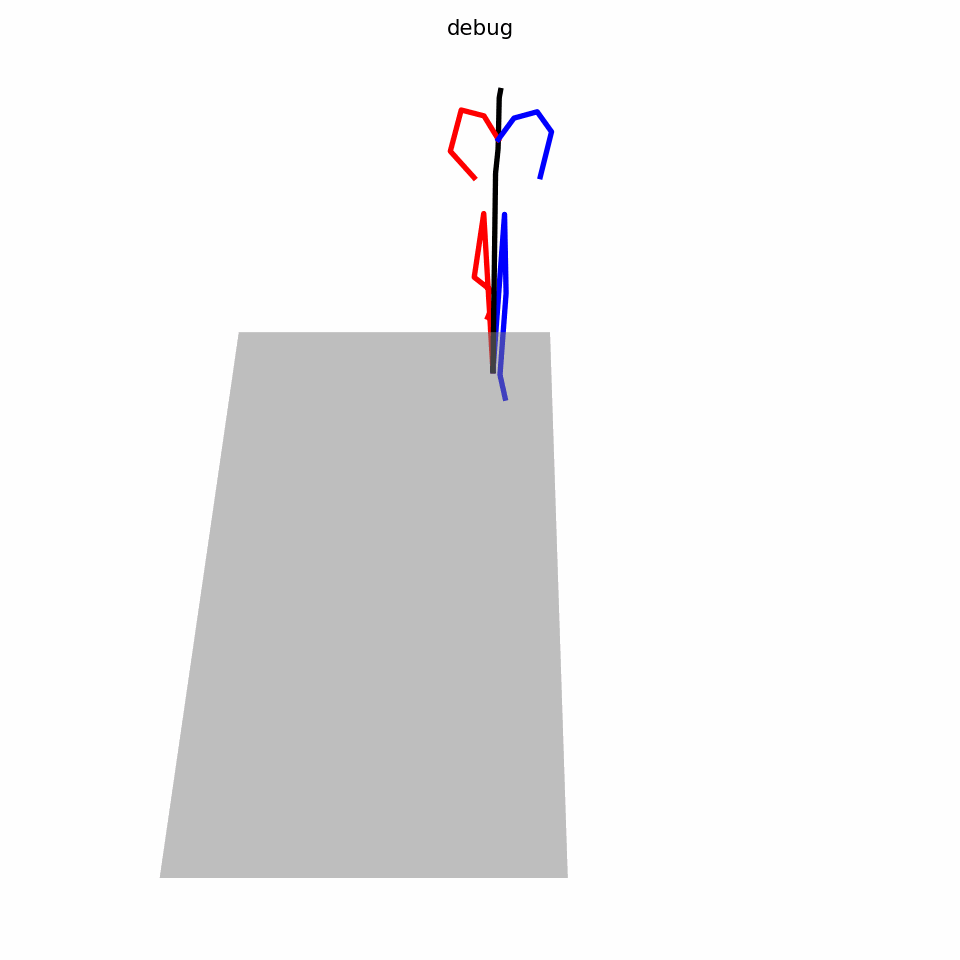

In [50]:
saved_name = './results/debug_repr/2.gif'

pose_vis = plot_3d.draw_to_batch(new_xyz_ric.detach().cpu().numpy(), ['debug'], [saved_name])
b64 = base64.b64encode(open(saved_name,'rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))

In [36]:
xyz_ric = recover_from_ric((motion_data).float(), 22)
xyz_ric = xyz_ric.reshape(1, -1, 22, 3)

In [37]:
saved_name = './results/debug_repr/1.gif'

pose_vis = plot_3d.draw_to_batch(xyz_ric.detach().cpu().numpy(), ['debug'], [saved_name])



In [ ]:
b64 = base64.b64encode(open(saved_name,'rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))

In [54]:
motion_files = os.listdir('/home/tdngo/Workspace/motion_ws/T2M-GPT/dataset/HumanML3D/new_joint_vecs')

data_list = []
for motion_file in tqdm(motion_files):
    motion = np.load(os.path.join('./dataset/HumanML3D/new_joint_vecs', motion_file))
    motion = torch.from_numpy(motion)
    
    r_rot_ang, r_pos_norot, _, _ = recover_root_rot_pos3(motion)
    new_motion = torch.cat([r_rot_ang[:, None], r_pos_norot, motion[..., 4:]], axis=-1)

    new_motion = new_motion.numpy()

    np.save(os.path.join('./dataset/HumanML3D/new_joint_vecs_absolute_root', motion_file), new_motion)

    data_list.append(new_motion)




100%|██████████| 29228/29228 [00:17<00:00, 1633.49it/s]


In [55]:
joints_num = 22
data = np.concatenate(data_list, axis=0)
Mean = data.mean(axis=0)
Std = data.std(axis=0)
Std[0:1] = Std[0:1].mean() / 1.0
Std[1:3] = Std[1:3].mean() / 1.0
Std[3:4] = Std[3:4].mean() / 1.0
Std[4: 4+(joints_num - 1) * 3] = Std[4: 4+(joints_num - 1) * 3].mean() / 1.0
Std[4+(joints_num - 1) * 3: 4+(joints_num - 1) * 9] = Std[4+(joints_num - 1) * 3: 4+(joints_num - 1) * 9].mean() / 1.0
Std[4+(joints_num - 1) * 9: 4+(joints_num - 1) * 9 + joints_num*3] = Std[4+(joints_num - 1) * 9: 4+(joints_num - 1) * 9 + joints_num*3].mean() / 1.0
Std[4 + (joints_num - 1) * 9 + joints_num * 3: ] = Std[4 + (joints_num - 1) * 9 + joints_num * 3: ].mean() / 1.0

assert 8 + (joints_num - 1) * 9 + joints_num * 3 == Std.shape[-1]

np.save(os.path.join('./dataset/HumanML3D', 'Mean_absolute_root.npy'), Mean)
np.save(os.path.join('./dataset/HumanML3D', 'Std_absolute_root.npy'), Std)